In [6]:
from lxml import etree

# Lade die CityGML-Datei
tree = etree.parse('./Data/696_5346.gml')

# Root of xml tree
root = tree.getroot()


# explore tree
#for elem in root.iter():
#    print(f"{elem.tag}: {elem.text}")

In [7]:
# Suche nach dem gml:Envelope Element
from pyproj import CRS
envelope = root.find('.//gml:Envelope', namespaces=ns)
 
# Extrahiere das srsName Attribut
if envelope is not None:
    srs_name = envelope.get('srsName')
    print(f"Koordinatensystem (srsName): {srs_name}")
    srsName = "EPSG:25832"
    crs = CRS.from_string(srsName)
    print(crs)
else:
    print("gml:Envelope Element nicht gefunden.")


Koordinatensystem (srsName): urn:adv:crs:ETRS89_UTM32*DE_DHHN2016_NH
EPSG:25832


In [8]:
import pandas as pd
import os
import lxml.etree as ET
import re

# Define the namespaces used in the CityGML file
ns = {
        'core': "http://www.opengis.net/citygml/2.0",
        'gml': "http://www.opengis.net/gml",
        'bldg' : 'http://www.opengis.net/citygml/building/2.0',
        'energy' : 'http://www.sig3d.org/citygml/2.0/energy/1.0',
        # Add other necessary namespaces based on the file content
    }
tree = etree.parse('./Data/696_5346.gml')
root = tree.getroot()
# Find all buildings and get the data
#for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
#    building_id = building.get('{http://www.opengis.net/gml}id')
namespaces = {
    'xAL': 'urn:oasis:names:tc:ciq:xal:3',
    'bldg': 'http://www.example.com/building'
}
address_df = {
    "bldg_id": [],
    "addr:city": [],
    "addr:street": [],
    "addr:housenumber": [],
}
pattern = r'^(.*\S)\s(\d+\w*)$'

for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
    building_id = building.get('{http://www.opengis.net/gml}id')
    address_node = building.find('.//{*}address')
    if address_node:
        street = address_node.find('.//{*}ThoroughfareName', namespaces).text
        inverted_street = street[::-1]
        street_number = inverted_street.split(" ")[0][::-1]
        street_name = inverted_street.split(" ")[1][::-1]
        city = address_node.find('.//{*}LocalityName', namespaces).text
        address_df["addr:city"].append(city)
        address_df["addr:street"].append(street_name)
        address_df["addr:housenumber"].append(street_number)
        #address_df["addr:street"].append(street.split(" ")[0])
    else:
        address_df["addr:city"].append(None)
        address_df["addr:street"].append(None)
        address_df["addr:housenumber"].append(None)
    address_df["bldg_id"].append(building_id)
#print(address_df)
df = pd.DataFrame(data = address_df, columns = address_df.keys()) 

/tmp/ipykernel_324927/1034857516.py:36: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if address_node:


In [9]:
df.head()

,bldg_id,addr:city,addr:street,addr:housenumber
0,DEBY_LOD2_5284360,Garching b.München,Watzmannring,50
1,DEBY_LOD2_5240624,None,None,None
2,DEBY_LOD2_5239436,None,None,None
3,DEBY_LOD2_5239376,None,None,None
4,DEBY_LOD2_5197168,Garching b.München,Hardtweg,5


In [10]:
# Map GML ID to CEA ID 
from lxml import etree
import shapely.geometry as geom
import matplotlib.pyplot as plt
import geopandas as gpd

ns = {
    'gml': 'http://www.opengis.net/gml',
    'bldg': 'http://www.opengis.net/citygml/building/2.0',
     'bldg' :"http://www.opengis.net/citygml/building/1.0"
}
# Code taken from https://github.com/TUB-DVG/TECDEM/blob/main/experiments/92a_ModelUpdatedGML.ipynb 

# Extract building geometries along with their IDs

def extract_ground_surface_polygons_with_ids(gml_root):
    buildings = []

    # Iterate over each building
    for bldg in gml_root.findall('.//{*}Building', ns):
        bldg_id = bldg.get('{http://www.opengis.net/gml}id')
        #print(bldg)

        # Find all GroundSurface elements within the boundedBy elements
        for ground_surface in bldg.findall('.//{*}GroundSurface', ns):
            pos_list_elements = ground_surface.findall('.//gml:posList', ns)
            if pos_list_elements is not None:
                for geom_elem in pos_list_elements:
                    pos_list = geom_elem.text.split()
                    if len(pos_list) % 3 != 0:
                        print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                        continue
                    try:
                        # Convert coordinates to a 2D polygon (ignoring z-values)
                        exterior_coords = []
                        interior_coords = []
                        
                        # Find exterior coordinates
                        exterior = ground_surface.find('.//gml:exterior//gml:posList', ns)
                        if exterior is not None:
                            exterior_pos_list = exterior.text.split()
                            exterior_coords = [(float(exterior_pos_list[i]), float(exterior_pos_list[i + 1])) for i in range(0, len(exterior_pos_list), 3)]
                        
                        # Find interior coordinates
                        interiors = ground_surface.findall('.//gml:interior//gml:posList', ns)
                        for interior in interiors:
                            interior_pos_list = interior.text.split()
                            interior_coords.append([(float(interior_pos_list[i]), float(interior_pos_list[i + 1])) for i in range(0, len(interior_pos_list), 3)])
                        
                        # Create polygon with exterior and interior (holes)
                        polygon = geom.Polygon(exterior_coords, interior_coords)
                        buildings.append({'geometry': polygon, 'gml_id': bldg_id})
                    except Exception as e:
                        print(f"Error creating polygon for building {bldg_id}: {e}")
            else:
                # Alternatively, check for 'Polygon' elements under GroundSurface
                for poly in ground_surface.findall('.//gml:Polygon', ns):
                    exterior_coords = []
                    interior_coords = []
                    
                    # Find exterior coordinates
                    exterior = poly.find('.//gml:exterior//gml:posList', ns)
                    if exterior is not None:
                        exterior_pos_list = exterior.text.split()
                        if len(exterior_pos_list) % 3 != 0:
                            print(f"Warning: exterior posList does not contain triplets of coordinates: {exterior_pos_list}")
                            continue
                        exterior_coords = [(float(exterior_pos_list[i]), float(exterior_pos_list[i + 1])) for i in range(0, len(exterior_pos_list), 3)]
                    
                    # Find interior coordinates
                    interiors = poly.findall('.//gml:interior//gml:posList', ns)
                    for interior in interiors:
                        interior_pos_list = interior.text.split()
                        if len(interior_pos_list) % 3 != 0:
                            print(f"Warning: interior posList does not contain triplets of coordinates: {interior_pos_list}")
                            continue
                        interior_coords.append([(float(interior_pos_list[i]), float(interior_pos_list[i + 1])) for i in range(0, len(interior_pos_list), 3)])
                    
                    try:
                        # Create polygon with exterior and interior (holes)
                        polygon = geom.Polygon(exterior_coords, interior_coords)
                        buildings.append({'geometry': polygon, 'gml_id': bldg_id})
                    except Exception as e:
                        print(f"Error creating polygon for building {bldg_id}: {e}")

    return buildings



# Now, update the code to use the modified function
list_buildings = []
tree = etree.parse('./Data/696_5346.gml')
root = tree.getroot()
# Use the modified function that extracts only ground surfaces
print(root)
buildings = extract_ground_surface_polygons_with_ids(root)
list_buildings.extend(buildings)  # Use extend to flatten the list



<Element {http://www.opengis.net/citygml/1.0}CityModel at 0x7f42b2c445c0>


In [18]:

import osmnx as ox
import geopandas as gpd

place_name = "Garching b. München"
area = ox.geocode_to_gdf(place_name)

tags = {'building': True}   

buildings_osm = ox.features_from_place(place_name, tags)
buildings_osm.head()


access amenity parking  \
element_type osmid                               
node         2246425108    NaN     NaN     NaN   
             5763636116    NaN     NaN     NaN   
             9348944907    NaN     NaN     NaN   
way          22998817      NaN     NaN     NaN   
             22998818      NaN     NaN     NaN   

                                                                  geometry  \
element_type osmid                                                           
node         2246425108                          POINT (11.63661 48.24966)   
             5763636116                          POINT (11.63361 48.24940)   
             9348944907                          POINT (11.67796 48.26679)   
way          22998817    POLYGON ((11.67546 48.26889, 11.67586 48.26885...   
             22998818    POLYGON ((11.67805 48.26933, 11.67884 48.26924...   

                        level wheelchair addr:housename             addr:city  \
element_type osmid                                                              
node         2246425108   NaN        NaN            NaN                   NaN   
             5763636116   NaN        NaN            NaN                   NaN   
             9348944907   NaN        NaN            NaN                   NaN   
way          22998817     NaN        NaN            NaN  Garching bei München   
             22998818     NaN        yes            NaN  Garching bei München   

                        addr:country addr:housenumber  ... climbing type  \
element_type osmid                                     ...                 
node         2246425108          NaN               65  ...      NaN  NaN   
             5763636116          NaN               37  ...      NaN  NaN   
             9348944907          NaN              NaN  ...      NaN  NaN   
way          22998817             DE                4  ...      NaN  NaN   
             22998818             DE                3  ...      NaN  NaN   

                        temporary wheelchair:description college  \
element_type osmid                                                 
node         2246425108       NaN                    NaN     NaN   
             5763636116       NaN                    NaN     NaN   
             9348944907       NaN                    NaN     NaN   
way          22998817         NaN                    NaN     NaN   
             22998818         NaN                    NaN     NaN   

                        operator:type area building:flats house ways  
element_type osmid                                                    
node         2246425108           NaN  NaN            NaN   NaN  NaN  
             5763636116           NaN  NaN            NaN   NaN  NaN  
             9348944907           NaN  NaN            NaN   NaN  NaN  
way          22998817             NaN  NaN            NaN   NaN  NaN  
             22998818             NaN  NaN            NaN   NaN  NaN  

[5 rows x 191 columns]

In [23]:
unique_level1 = buildings_osm.index.get_level_values('element_type').unique()
unique_level1

Index(['node', 'way', 'relation'], dtype='object', name='element_type')

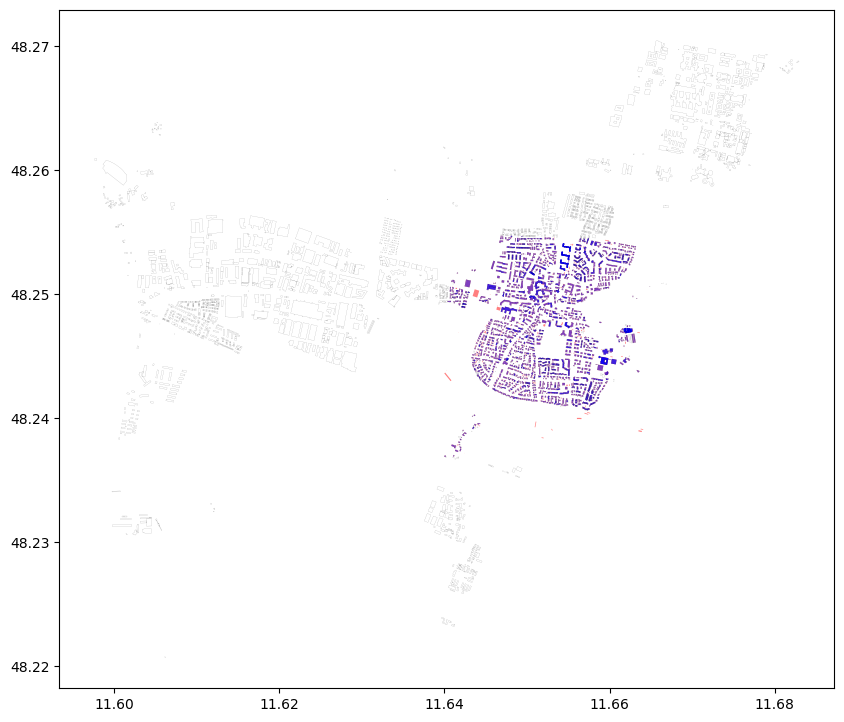

In [12]:
# Check if we have extracted any buildings
if not list_buildings:
    print("No buildings were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    
    buildings_gdf = gpd.GeoDataFrame(list_buildings, crs='EPSG:25832')
    buildings_gdf = buildings_gdf.to_crs('EPSG:4326')
    # Select columns using a list instead of a tuple
    columns_to_keep = ['addr:street', 'addr:housenumber','addr:city', 'geometry']
    blocks_gdf = buildings_osm[columns_to_keep]
    # Check if buildings are within blocks
    buildings_gdf = buildings_gdf.reset_index(drop=True)
    buildings_osm = buildings_osm.reset_index(drop=True)
    within_blocks = gpd.sjoin(buildings_gdf, blocks_gdf, how='inner', predicate='intersects')


    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=0.05, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()

In [53]:
within_blocks.head()

,geometry,gml_id,index_right,addr:street,addr:housenumber,addr:city
0,"POLYGON ((11.66288 48.25296, 11.66287 48.25294...",DEBY_LOD2_5284360,954,Watzmannring,50,Garching bei München
1,"POLYGON ((11.64987 48.24262, 11.64974 48.24261...",DEBY_LOD2_5240624,2739,NaN,NaN,NaN
2,"POLYGON ((11.65086 48.24136, 11.65087 48.24140...",DEBY_LOD2_5239436,1967,NaN,NaN,NaN
3,"POLYGON ((11.65378 48.24130, 11.65378 48.24132...",DEBY_LOD2_5239376,2111,NaN,NaN,NaN
4,"POLYGON ((11.64138 48.24939, 11.64138 48.24943...",DEBY_LOD2_5197168,502,NaN,NaN,NaN


<bldg:address>
<Address><xalAddress><xAL:AddressDetails>
 <xAL:Country>
  <xAL:CountryName>Germany</xAL:CountryName>
  <xAL:Locality Type="Town">
   <xAL:LocalityName>Garching b.München</xAL:LocalityName>
   <xAL:Thoroughfare Type="Street">
    <xAL:ThoroughfareName>Watzmannring 50</xAL:ThoroughfareName>
   </xAL:Thoroughfare>
  </xAL:Locality>
 </xAL:Country>
</xAL:AddressDetails></xalAddress>
</Address>
</bldg:address>


In [54]:
address_df = { 'bldg_id' : [], 'addr:city' : [],
    'addr:housenumber' : [],
    'addr:street' : [],
    'addr:postcode' : [], 

 }

In [13]:
namespaces = {
    'xAL': 'urn:oasis:names:tc:ciq:xal:3',
    'bldg': 'http://www.example.com/building'
}
for building in root.findall('.//{*}Building'):
    # Get all IDs and yoc
    building_id = building.get('{http://www.opengis.net/gml}id')
    address_node = building.find('.//{*}address')
    if address_node:
        
        street = address_node.find('.//{*}ThoroughfareName', namespaces).text
        print(street)
        city = address_node.find('.//{*}LocalityName', namespaces).text
        address_df["addr:city"].append(city)
        address_df["addr:street"].append(street.split(" ")[0])
        address_df["addr:street"].append(street.split(" ")[1])
    address_df["bldg_id"].append(building_id)
    print(address_df)

/tmp/ipykernel_324927/3218632517.py:9: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if address_node:
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [3]:
import pandas as pd

import os

from lxml import etree

import re


# Define the namespaces used in the CityGML file

ns = {

        'core': "http://www.opengis.net/citygml/2.0",

        'gml': "http://www.opengis.net/gml",

        'bldg' : 'http://www.opengis.net/citygml/building/2.0',

        'energy' : 'http://www.sig3d.org/citygml/2.0/energy/1.0',

        # Add other necessary namespaces based on the file content

    }

tree = etree.parse('./Data/696_5346.gml')

root = tree.getroot()

# Find all buildings and get the data

#for building in root.findall('.//{*}Building'):

    # Get all IDs and yoc

#    building_id = building.get('{http://www.opengis.net/gml}id')

namespaces = {

    'xAL': 'urn:oasis:names:tc:ciq:xal:3',

    'bldg': 'http://www.example.com/building'

}

address_df = {

    "bldg_id": [],

    "addr:city": [],

    "addr:street": [],

    "addr:housenumber": [],

}

pattern = r'^(.*\S)\s(\d+\w*)$'


for building in root.findall('.//{*}Building'):

    # Get all IDs and yoc

    building_id = building.get('{http://www.opengis.net/gml}id')

    address_node = building.find('.//{*}address')

    if address_node:

        street = address_node.find('.//{*}ThoroughfareName', namespaces).text

        inverted_street = street[::-1]

        street_number = inverted_street.split(" ")[0][::-1]

        street_name = inverted_street.split(" ")[1][::-1]

        city = address_node.find('.//{*}LocalityName', namespaces).text

        address_df["addr:city"].append(city)

        address_df["addr:street"].append(street_name)

        address_df["addr:housenumber"].append(street_number)

        #address_df["addr:street"].append(street.split(" ")[0])

    else:

        address_df["addr:city"].append(None)

        address_df["addr:street"].append(None)

        address_df["addr:housenumber"].append(None)

    address_df["bldg_id"].append(building_id)

#print(address_df)

df = pd.DataFrame(data = address_df, columns = address_df.keys())

/tmp/ipykernel_324927/4095927628.py:69: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if address_node:


In [14]:
df.head()

,bldg_id,addr:city,addr:street,addr:housenumber
0,DEBY_LOD2_5284360,Garching b.München,Watzmannring,50
1,DEBY_LOD2_5240624,None,None,None
2,DEBY_LOD2_5239436,None,None,None
3,DEBY_LOD2_5239376,None,None,None
4,DEBY_LOD2_5197168,Garching b.München,Hardtweg,5


In [15]:
merged_df = pd.merge(within_blocks, df, how='inner', on=['addr:street','addr:housenumber', 'addr:city'])

In [16]:
merged_df.head()

,geometry,gml_id,index_right0,index_right1,addr:street,addr:housenumber,addr:city,bldg_id
0,"POLYGON ((11.64987 48.24262, 11.64974 48.24261...",DEBY_LOD2_5240624,way,181655810,NaN,NaN,NaN,DEBY_LOD2_5240624
1,"POLYGON ((11.64987 48.24262, 11.64974 48.24261...",DEBY_LOD2_5240624,way,181655810,NaN,NaN,NaN,DEBY_LOD2_5239436
2,"POLYGON ((11.64987 48.24262, 11.64974 48.24261...",DEBY_LOD2_5240624,way,181655810,NaN,NaN,NaN,DEBY_LOD2_5239376
3,"POLYGON ((11.64987 48.24262, 11.64974 48.24261...",DEBY_LOD2_5240624,way,181655810,NaN,NaN,NaN,DEBY_LOD2_5239326
4,"POLYGON ((11.64987 48.24262, 11.64974 48.24261...",DEBY_LOD2_5240624,way,181655810,NaN,NaN,NaN,DEBY_LOD2_104553055


In [17]:
len(merged_df)

4305704